In [ ]:
# Import necessary modules
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

here = os.path.dirname(os.path.abspath("__file__"))
project_root = os.path.abspath(os.path.join(here, '../../'))
sys.path.insert(0, project_root)

from core.mpc.mpc_run import MPC
from core.mpc.mpc_params import MPCParams

from core.model.model_carrying_capacities import ModelCarryingCapacities
from smartfarm.core.plotting.plotting_colors import ModelColors
from core.model.model_disturbances import ModelDisturbances
from core.model.model_growth_rates import ModelGrowthRates
from core.model.model_initial_conditions import ModelInitialConditions
from core.model.model_params import ModelParams
from core.model.model_typical_disturbances import ModelTypicalDisturbances
from core.model.model_sensitivities import ModelSensitivities

In [ ]:
# Color blind friendly color palette
colors = ModelColors()

# Enable LaTeX rendering for all text
plt.rcParams['text.usetex'] = True

# Optionally, set the font family to match classic LaTeX style (Computer Modern)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif']  = ['Computer Modern Roman']

# Set the font size preferences
plt.rcParams['axes.labelsize']   = 14 
plt.rcParams['axes.titlesize']   = 16 
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['xtick.labelsize']  = 12
plt.rcParams['ytick.labelsize']  = 12

# Set default plot trace color
plt.rcParams['lines.color'] = colors.vivid_green

## Model Parameters

In [3]:
# Set ModelParams (time stepping)
model_params = ModelParams(
    dt               = 0.1,  # hours/step
    simulation_hours = 2900, # hours
    closed_form      = False,
    verbose          = True
)

In [4]:
# Set ModelCarryingCapacities
carrying_capacities = ModelCarryingCapacities(
    kh = 3.0,  # m
    kA = 0.65, # m2
    kN = 20,   # number of leaves
    kc = 1000, # number of spikelets
    kP = 0.25  # kg
)

In [5]:
# Set ModelGrowthRates
growth_rates = ModelGrowthRates(
    ah = 0.01,   # 1/hr
    aA = 0.0105, # 1/hr
    aN = 0.011,  # 1/hr
    ac = 0.01,   # 1/hr
    aP = 0.005   # 1/hr
)

In [6]:
# Set ModelSensitivities
sensitivities = ModelSensitivities(
    sigma_W = 30,  # hrs
    sigma_F = 300, # hrs
    sigma_T = 30,  # hrs
    sigma_R = 30   # hrs
)

In [7]:
# Set ModelInitialConditions
initial_conditions = ModelInitialConditions(
    h0=carrying_capacities.kh/model_params.simulation_hours, # m/hr
    A0=carrying_capacities.kA/model_params.simulation_hours, # m2/hr
    N0=carrying_capacities.kN/model_params.simulation_hours, # number/hr
    c0=carrying_capacities.kc/model_params.simulation_hours, # number/hr
    P0=carrying_capacities.kP/model_params.simulation_hours  # kg/hr
)

## Cost function weights and MPC horizon

In [8]:
mpc_params = MPCParams()
horizon              = mpc_params.horizon
weight_fruit_biomass = mpc_params.weight_fruit_biomass
weight_irrigation    = mpc_params.weight_irrigation
weight_fertilizer    = mpc_params.weight_fertilizer

## Input Disturbances

In [9]:
# Hourly precipitation, radiation, and temperature from CSV
hourly_input_disturbances = pd.read_csv(
    '../../io/inputs/hourly_prcp_rad_temp_iowa.csv'
)

In [10]:
# Set ModelDisturbances
input_disturbances = ModelDisturbances(
    precipitation = hourly_input_disturbances['Hourly Precipitation (in)'].to_numpy(),
    radiation     = hourly_input_disturbances['Hourly Radiation (W/m2)'].to_numpy(),
    temperature   = hourly_input_disturbances['Temperature (C)'].to_numpy()
)

## Plot disturbances

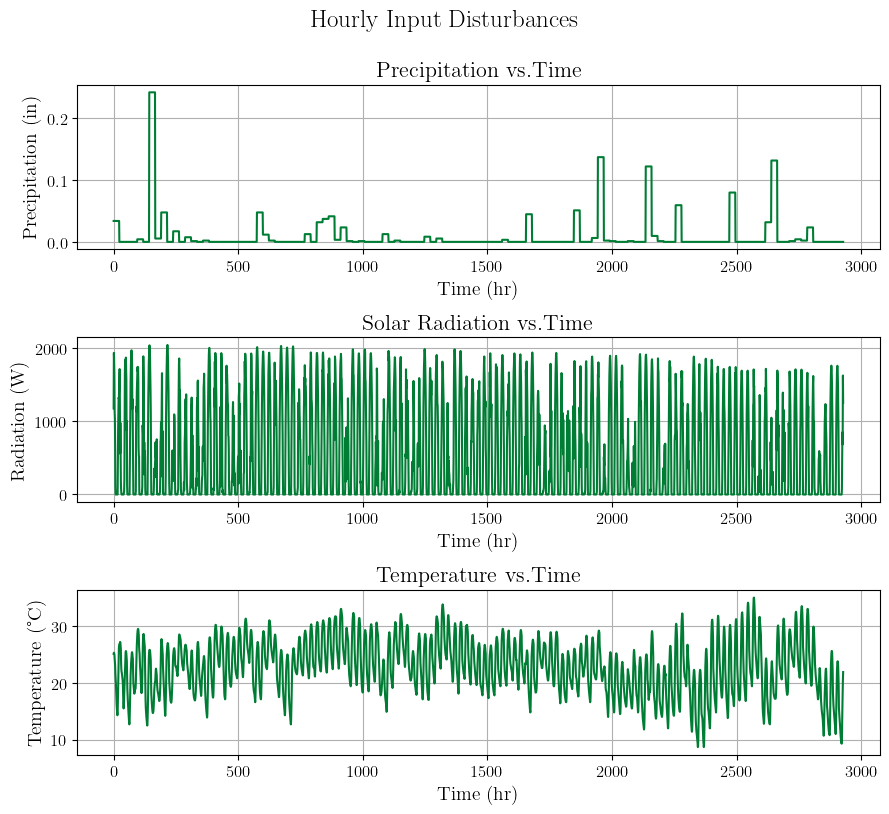

In [25]:
# Plot all of the input disturbances and control inputs
fig, axs = plt.subplots(3, 1, figsize=(9, 9))
time = np.arange(len(input_disturbances.precipitation))

# Precipitation
axs[0].plot(time, input_disturbances.precipitation, color=colors.vivid_green)
axs[0].set_xlabel(r'Time (hr)')
axs[0].set_ylabel(r'Precipitation (in)')
axs[0].set_title(r'Precipitation vs.Time')
axs[0].grid(True)

# Solar Radiation
axs[1].plot(time, input_disturbances.radiation, color=colors.vivid_green)
axs[1].set_xlabel(r'Time (hr)')
axs[1].set_ylabel(r'Radiation (W)')
axs[1].set_title(r'Solar Radiation vs.Time')
axs[1].grid(True)

# Fruit Biomass
axs[2].plot(time, input_disturbances.temperature, color=colors.vivid_green)
axs[2].set_xlabel(r'Time (hr)')
axs[2].set_ylabel(r'Temperature (\textdegree C)')
axs[2].set_title(r'Temperature vs.Time')
axs[2].grid(True)

fig.suptitle(r'Hourly Input Disturbances', y=0.9)
plt.tight_layout(rect=[0, 0, 1, 0.9])
plt.show()

In [ ]:
# Convert inputs from hourly to simulation time steps
from core.model.model_helpers import get_sim_inputs_from_hourly

temperature   = get_sim_inputs_from_hourly(input_disturbances.temperature,   model_params.dt, simulation_hours, mode='split')
radiation     = get_sim_inputs_from_hourly(input_disturbances.radiation,     model_params.dt, simulation_hours, mode='split')
precipitation = get_sim_inputs_from_hourly(input_disturbances.precipitation, model_params.dt, simulation_hours, mode='split')

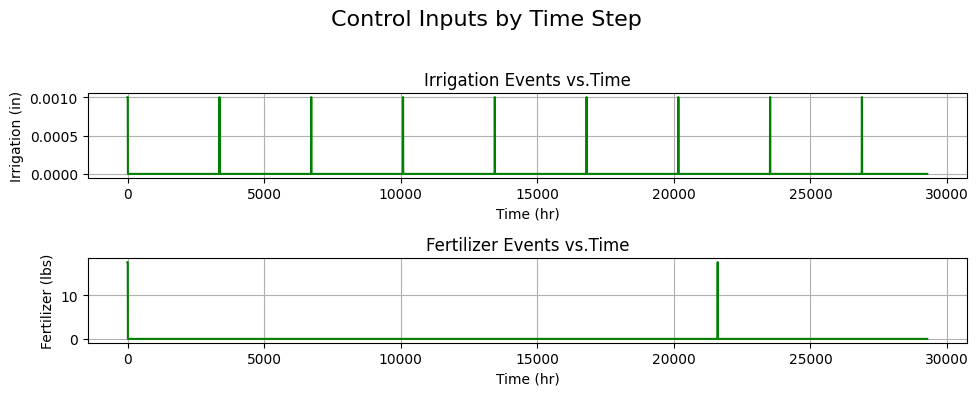

In [14]:
# Plot all of the control inputs
fig, axs = plt.subplots(2, 1, figsize=(10, 4))
time = np.arange(len(irrigation))

# Irrigation Events
axs[0].plot(time, irrigation, color='green')
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Irrigation (in)')
axs[0].set_title(f'Irrigation Events vs.Time')
axs[0].grid(True)

# Fertilizer Events
axs[1].plot(time, fertilizer, color='green')
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Fertilizer (lbs)')
axs[1].set_title(f'Fertilizer Events vs.Time')
axs[1].grid(True)

fig.suptitle(f'Control Inputs by Time Step', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Optimal/Typical Values

In [15]:
default_typical_disturbances = ModelTypicalDisturbances()

typical_disturbances = ModelTypicalDisturbances(
    typical_water       = default_typical_disturbances.typical_water * model_params.dt,
    typical_fertilizer  = default_typical_disturbances.typical_fertilizer * model_params.dt,
    typical_temperature = default_typical_disturbances.typical_temperature * model_params.dt,
    typical_radiation   = default_typical_disturbances.typical_radiation * model_params.dt
)

## GA Params (just to use Member class)

In [16]:
# Genetic algorithm style inputs
ga_params = GeneticAlgorithmParams()

## Simulation of Plant Growth over Season

In [17]:
# Construct an instance of the Member class and get the cost
member = Member(
    ga_params            = ga_params,
    carrying_capacities  = carrying_capacities,
    disturbances         = input_disturbances,
    growth_rates         = growth_rates,
    initial_conditions   = initial_conditions,
    model_params         = model_params,
    typical_disturbances = typical_disturbances,
    sensitivities        = sensitivities,
    values = np.array([irrigation_frequency, irrigation_amount, fertilizer_frequency, fertilizer_amount])
)
member.get_cost()

/Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Smart Farm/smartfarm/src/smartfarm/core/ga/ga_member.py:204: RuntimeWarning: divide by zero encountered in divide
  nuW = np.exp(-1/3  * np.abs(cumulative_water       / (W_typ * np.arange(1, total_time_steps + 1) - 1)**2))


214.95851706471083

In [18]:
# Read results from the output csv file
output = pd.read_csv('output_get_cost.csv')

h = output['h'].to_numpy()
A = output['A'].to_numpy()
N = output['N'].to_numpy()
c = output['c'].to_numpy()
P = output['P'].to_numpy()

delayed_water       = output['delayed_water'].to_numpy()
delayed_fertilizer  = output['delayed_fertilizer'].to_numpy()
delayed_temperature = output['delayed_temperature'].to_numpy()
delayed_radiation   = output['delayed_radiation'].to_numpy()

cumulative_water       = output['cumulative_water'].to_numpy()
cumulative_fertilizer  = output['cumulative_fertilizer'].to_numpy()
cumulative_temperature = output['cumulative_temperature'].to_numpy()
cumulative_radiation   = output['cumulative_radiation'].to_numpy()

delta_cumulative_water       = output['delta_cumulative_water'].to_numpy()
delta_cumulative_fertilizer  = output['delta_cumulative_fertilizer'].to_numpy()
delta_cumulative_temperature = output['delta_cumulative_temperature'].to_numpy()
delta_cumulative_radiation   = output['delta_cumulative_radiation'].to_numpy()

nuW_values = output['nuW'].to_numpy()
nuF_values = output['nuF'].to_numpy()
nuT_values = output['nuT'].to_numpy()
nuR_values = output['nuR'].to_numpy()

ah_hat = output['ah_hat'].to_numpy()
aA_hat = output['aA_hat'].to_numpy()
aN_hat = output['aN_hat'].to_numpy()
ac_hat = output['ac_hat'].to_numpy()
aP_hat = output['aP_hat'].to_numpy()

kh_hat = output['kh_hat'].to_numpy()
kA_hat = output['kA_hat'].to_numpy()
kN_hat = output['kN_hat'].to_numpy()
kc_hat = output['kc_hat'].to_numpy()
kP_hat = output['kP_hat'].to_numpy()

## Plot crop growth results

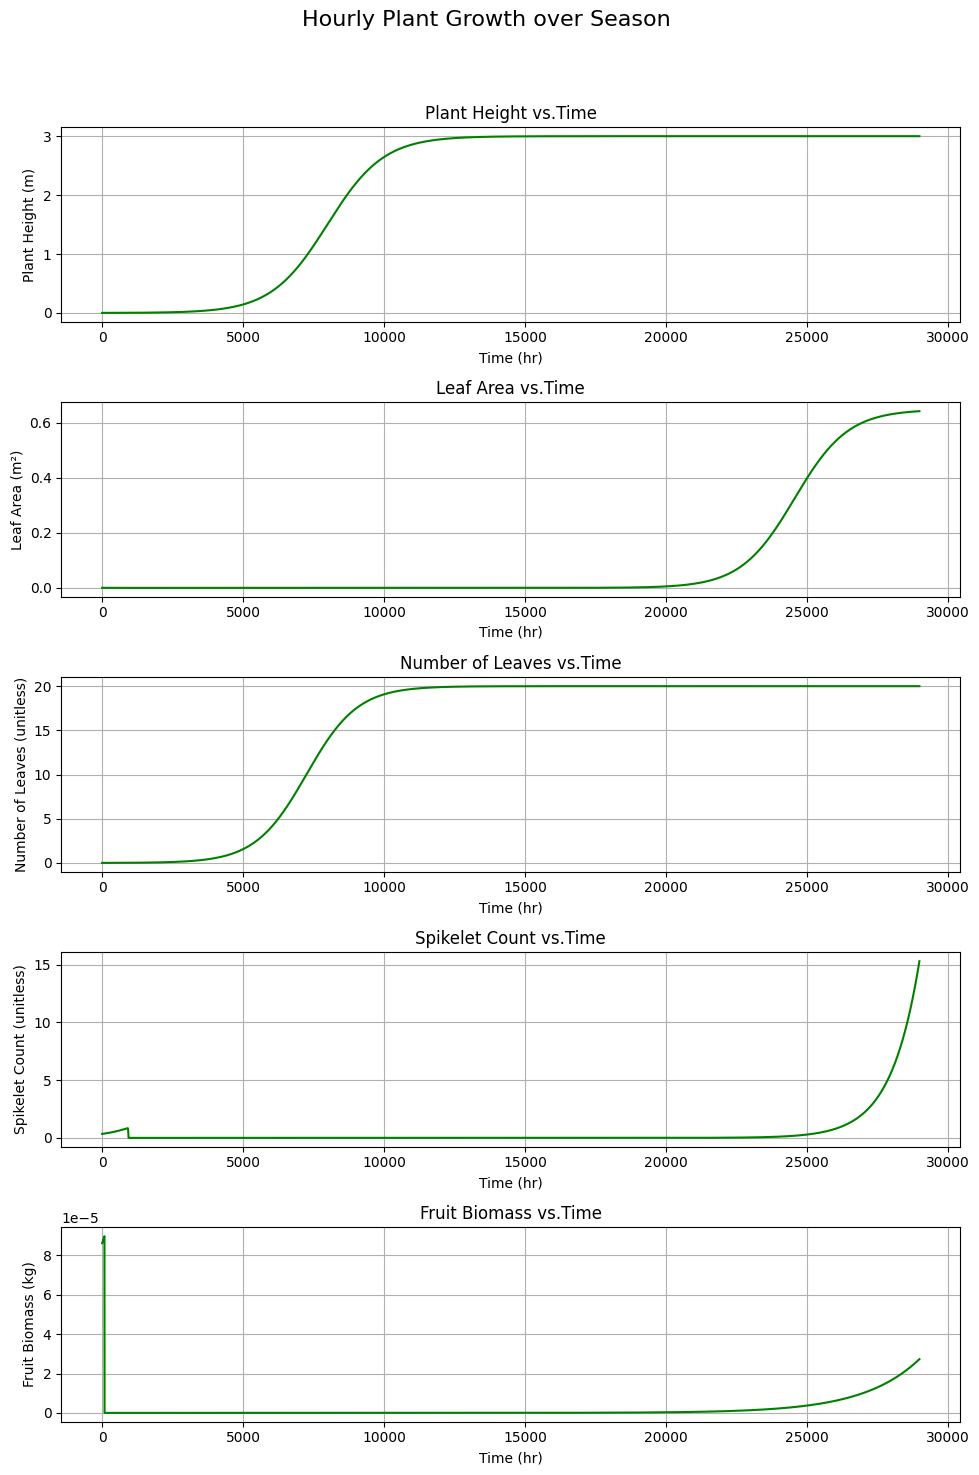

In [19]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass over time
fig, axs = plt.subplots(5, 1, figsize=(10, 15))
time = np.arange(len(h))

# Plant Height
axs[0].plot(time, h, color='green')
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Plant Height (m)')
axs[0].set_title(f'Plant Height vs.Time')
axs[0].grid(True)

# Leaf Area
axs[1].plot(time, A, color='green')
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Leaf Area (m²)')
axs[1].set_title(f'Leaf Area vs.Time')
axs[1].grid(True)

# Number of Leaves
axs[2].plot(time, N, color='green')
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Number of Leaves (unitless)')
axs[2].set_title(f'Number of Leaves vs.Time')
axs[2].grid(True)

# Spikelet Count
axs[3].plot(time, c, color='green')
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Spikelet Count (unitless)')
axs[3].set_title(f'Spikelet Count vs.Time')
axs[3].grid(True)

# Fruit Biomass
axs[4].plot(time, P, color='green')
axs[4].set_xlabel('Time (hr)')
axs[4].set_ylabel('Fruit Biomass (kg)')
axs[4].set_title(f'Fruit Biomass vs.Time')
axs[4].grid(True)

fig.suptitle(f'Hourly Plant Growth over Season', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [20]:
profit = weight_fruit_biomass * P[-1]
expenses = (weight_irrigation * np.sum(hourly_irrigation)
            + weight_fertilizer * np.sum(hourly_fertilizer))
revenue = profit - expenses

print(f'weight_fruit_biomass: {weight_fruit_biomass}')
print(f'weight_irrigation: {weight_irrigation}')
print(f'weight_fertilizer: {weight_fertilizer}')
print(f'Fruit biomass: {P[-1]}')

print(f'\n')

print(f'Profit: ${profit:.2f}')
print(f'Irrigation used (in): {np.sum(hourly_irrigation):.2f}, irrigation expense: ${weight_irrigation * np.sum(hourly_irrigation):.2f}')
print(f'Fertilizer used (lbs): {np.sum(hourly_fertilizer):.2f}, fertilizer expense: ${weight_fertilizer * np.sum(hourly_fertilizer):.2f}')
print(f'Expenses: ${expenses:.2f}')
print(f'Revenue: ${revenue:.2f}')

weight_fruit_biomass: 4450
weight_irrigation: 2.0
weight_fertilizer: 0.614
Fruit biomass: 2.7299536020039804e-05


Profit: $0.12
Irrigation used (in): 0.09, irrigation expense: $0.18
Fertilizer used (lbs): 350.00, fertilizer expense: $214.90
Expenses: $215.08
Revenue: $-214.96


## Plot input and disturbance evolution with delays taken into account

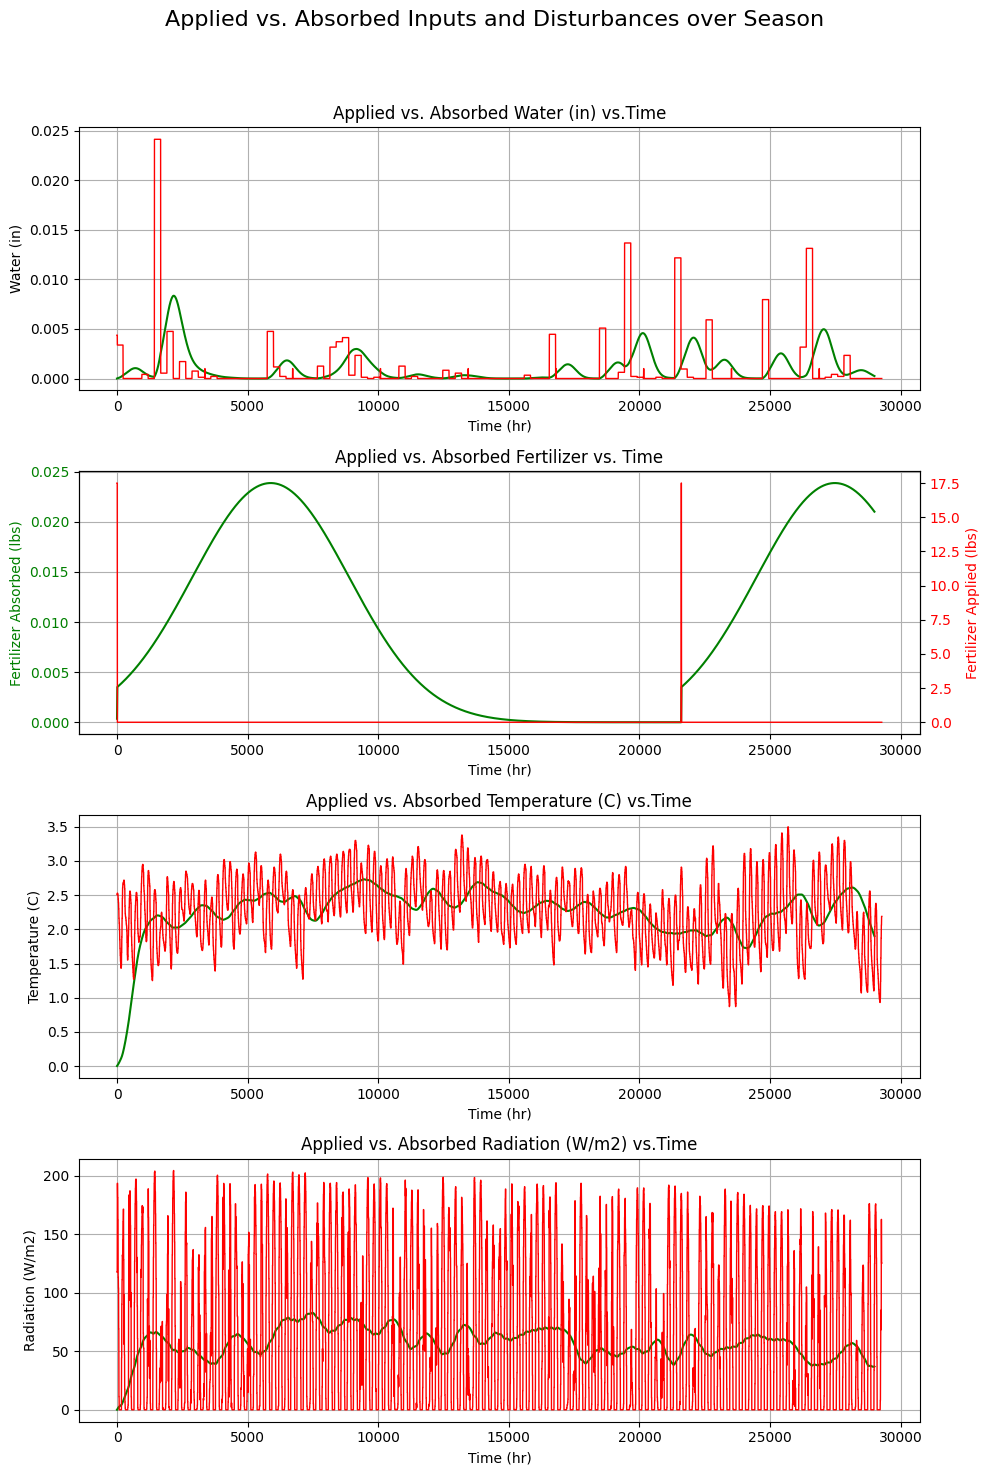

In [21]:
# Plot delayed water, fertilizer, temperature, and radiation over time
fig, axs = plt.subplots(4, 1, figsize=(10, 15))
time = np.arange(len(delayed_water))

# Delayed Water
axs[0].plot(time, delayed_water, color='green')
axs[0].plot(irrigation + precipitation, color='red', linewidth=1)
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Water (in)')
axs[0].set_title(f'Applied vs. Absorbed Water (in) vs.Time')
axs[0].grid(True)

# Delayed Fertilizer
axs[1].plot(time, delayed_fertilizer, color='green')
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Fertilizer Absorbed (lbs)', color='green')
axs[1].tick_params(axis='y', labelcolor='green')
axs[1].set_title('Applied vs. Absorbed Fertilizer vs. Time')
axs[1].grid(True)
ax2 = axs[1].twinx() # Create a second y-axis sharing the same x-axis
ax2.plot(np.arange(len(fertilizer)), fertilizer, color='red', linewidth=1) # Plot the second trace there
ax2.set_ylabel('Fertilizer Applied (lbs)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Delayed Temperature
axs[2].plot(time, delayed_temperature, color='green')
axs[2].plot(temperature, color='red', linewidth=1)
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Temperature (C)')
axs[2].set_title(f'Applied vs. Absorbed Temperature (C) vs.Time')
axs[2].grid(True)

# Delayed Radiation
axs[3].plot(time, delayed_radiation, color='green')
axs[3].plot(radiation, color='red', linewidth=1)
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Radiation (W/m2)')
axs[3].set_title(f'Applied vs. Absorbed Radiation (W/m2) vs.Time')
axs[3].grid(True)

fig.suptitle(f'Applied vs. Absorbed Inputs and Disturbances over Season', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Plot cumulative value evolution

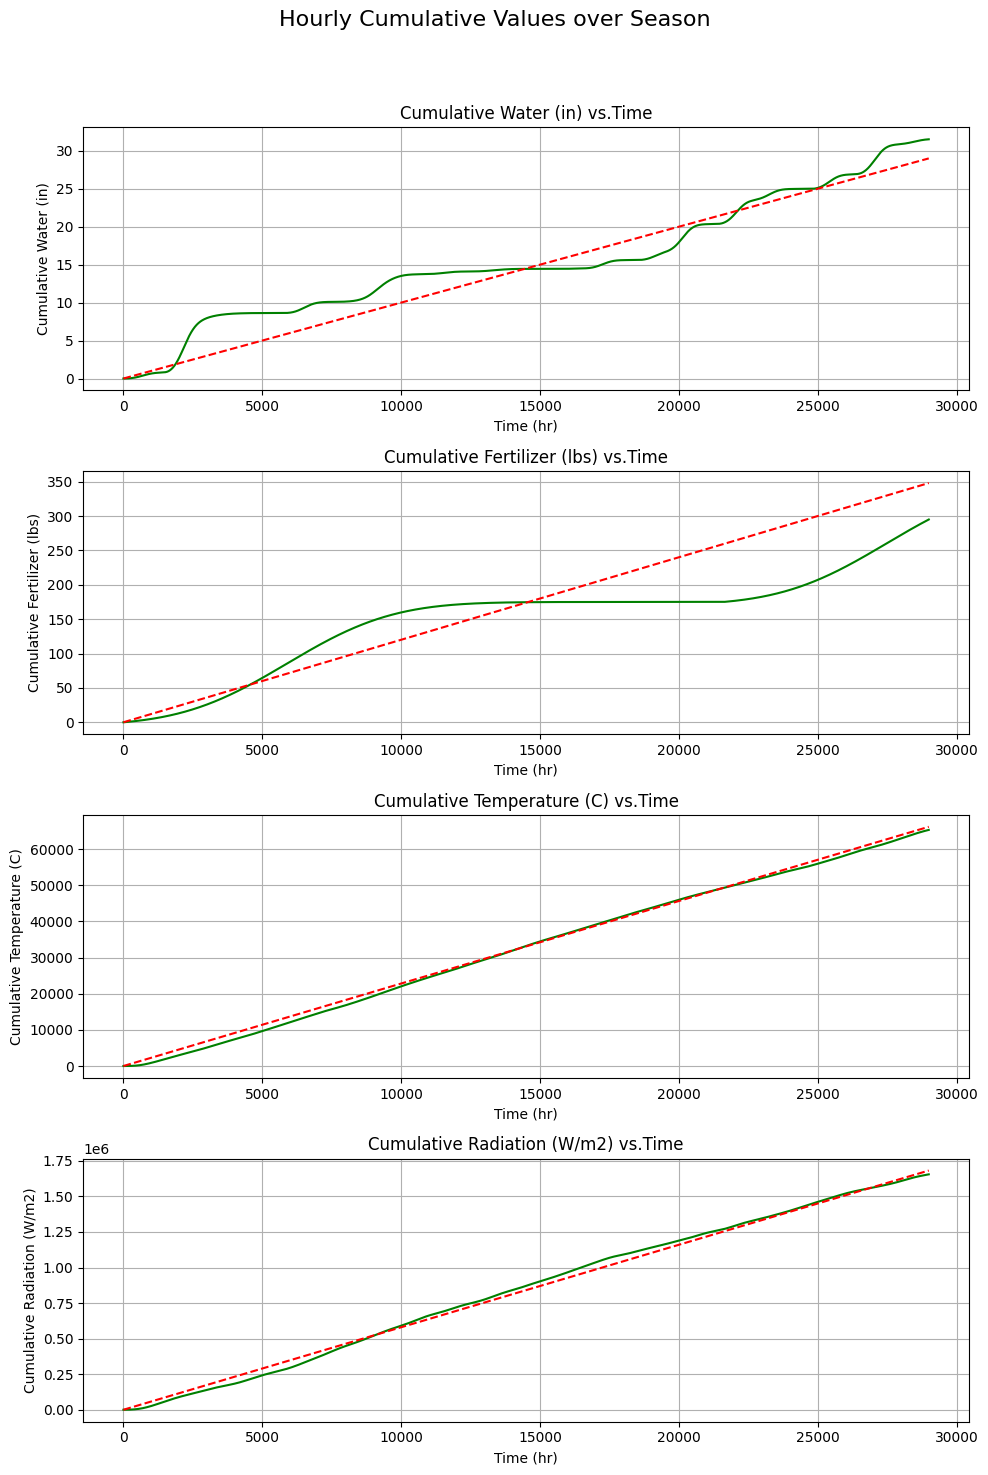

In [22]:
# Plot RC, TC, WC, and FC over time
fig, axs = plt.subplots(4, 1, figsize=(10, 15))
time = np.arange(len(cumulative_water))

R_typ = typical_disturbances.typical_radiation * time
T_typ = typical_disturbances.typical_temperature * time
W_typ = typical_disturbances.typical_water * time
F_typ = typical_disturbances.typical_fertilizer * time 

# Cumulative Water
axs[0].plot(time, cumulative_water, color='green')
axs[0].plot(W_typ, color='red', linestyle='--', linewidth=1.5)
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Cumulative Water (in)')
axs[0].set_title(f'Cumulative Water (in) vs.Time')
axs[0].grid(True)

# Cumulative Fertilizer
axs[1].plot(time, cumulative_fertilizer, color='green')
axs[1].plot(F_typ, color='red', linestyle='--', linewidth=1.5)
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Cumulative Fertilizer (lbs)')
axs[1].set_title(f'Cumulative Fertilizer (lbs) vs.Time')
axs[1].grid(True)

# Cumulative Temperature
axs[2].plot(time, cumulative_temperature, color='green')
axs[2].plot(T_typ, color='red', linestyle='--', linewidth=1.5)
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Cumulative Temperature (C)')
axs[2].set_title(f'Cumulative Temperature (C) vs.Time')
axs[2].grid(True)

# Cumulative Radiation
axs[3].plot(time, cumulative_radiation, color='green')
axs[3].plot(R_typ, color='red', linestyle='--', linewidth=1.5)
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Cumulative Radiation (W/m2)')
axs[3].set_title(f'Cumulative Radiation (W/m2) vs.Time')
axs[3].grid(True)

fig.suptitle(f'Hourly Cumulative Values over Season', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Plot the deltas between actual and expected cumulative value

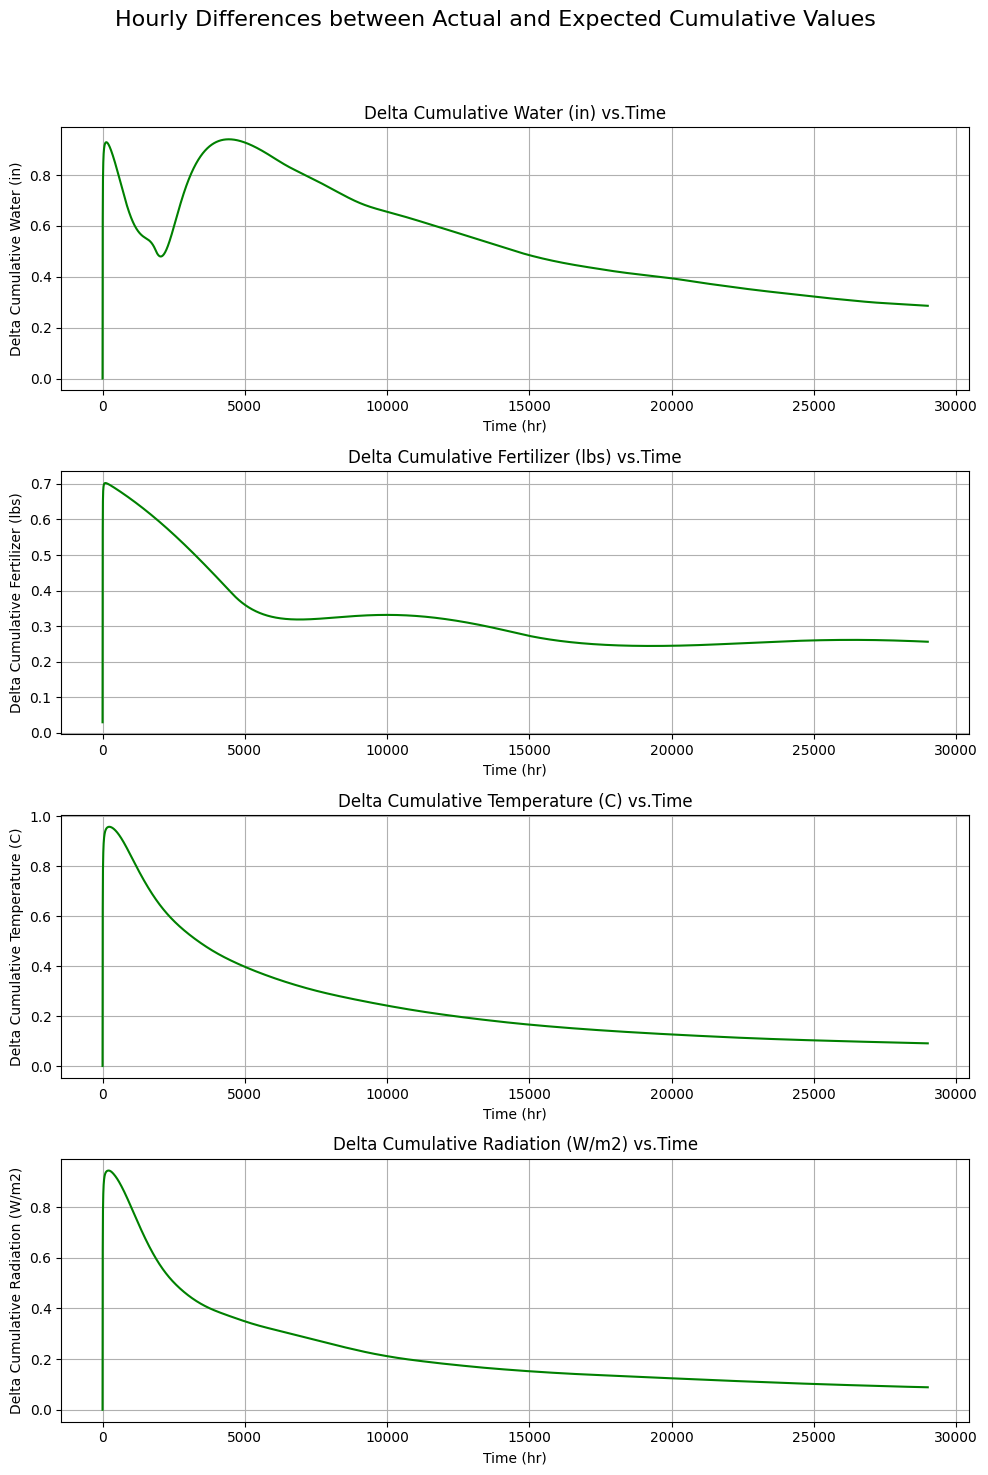

In [23]:
# Plot the difference between cumulative and typical cumulative disturbances over time
fig, axs = plt.subplots(4, 1, figsize=(10, 15))
time = np.arange(len(cumulative_water))

# Delta Cumulative Water
axs[0].plot(time, delta_cumulative_water, color='green')
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Delta Cumulative Water (in)')
axs[0].set_title(f'Delta Cumulative Water (in) vs.Time')
axs[0].grid(True)

# Delta Cumulative Fertilizer
axs[1].plot(time, delta_cumulative_fertilizer, color='green')
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Delta Cumulative Fertilizer (lbs)')
axs[1].set_title(f'Delta Cumulative Fertilizer (lbs) vs.Time')
axs[1].grid(True)

# Delta Cumulative Temperature
axs[2].plot(time, delta_cumulative_temperature, color='green')
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Delta Cumulative Temperature (C)')
axs[2].set_title(f'Delta Cumulative Temperature (C) vs.Time')
axs[2].grid(True)

# Delta Cumulative Radiation
axs[3].plot(time, delta_cumulative_radiation, color='green')
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Delta Cumulative Radiation (W/m2)')
axs[3].set_title(f'Delta Cumulative Radiation (W/m2) vs.Time')
axs[3].grid(True)

fig.suptitle(f'Hourly Differences between Actual and Expected Cumulative Values', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Plot nutrient factor evolution

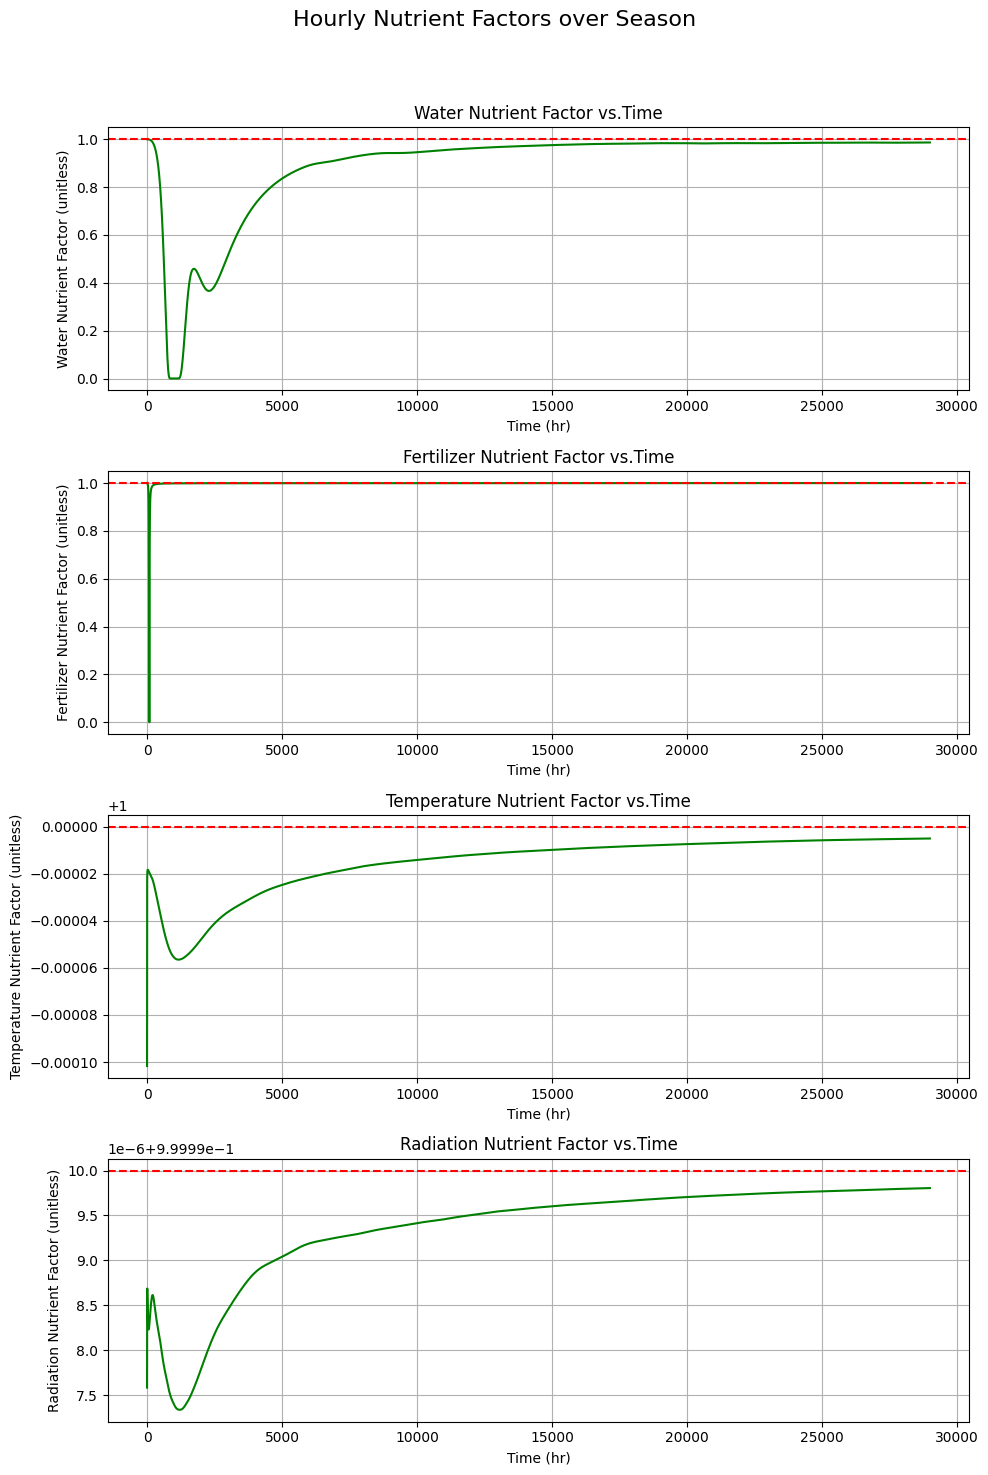

In [24]:
# Plot nuW, nuF, nuT, and nuF over time
fig, axs = plt.subplots(4, 1, figsize=(10, 15))
time = np.arange(len(nuW_values))

# Water Nutrient Factor
axs[0].plot(time, nuW_values, color='green')
axs[0].axhline(y=1, color='red', linestyle='--', linewidth=1.5)
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Water Nutrient Factor (unitless)')
axs[0].set_title(f'Water Nutrient Factor vs.Time')
axs[0].grid(True)

# Fertilizer Nutrient Factor
axs[1].plot(time, nuF_values, color='green')
axs[1].axhline(y=1, color='red', linestyle='--', linewidth=1.5)
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Fertilizer Nutrient Factor (unitless)')
axs[1].set_title(f'Fertilizer Nutrient Factor vs.Time')
axs[1].grid(True)

# Temperature Nutrient Factor
axs[2].plot(time, nuT_values, color='green')
axs[2].axhline(y=1, color='red', linestyle='--', linewidth=1.5)
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Temperature Nutrient Factor (unitless)')
axs[2].set_title(f'Temperature Nutrient Factor vs.Time')
axs[2].grid(True)

# Radiation Nutrient Factor
axs[3].plot(time, nuR_values, color='green')
axs[3].axhline(y=1, color='red', linestyle='--', linewidth=1.5)
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Radiation Nutrient Factor (unitless)')
axs[3].set_title(f'Radiation Nutrient Factor vs.Time')
axs[3].grid(True)

fig.suptitle(f'Hourly Nutrient Factors over Season', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Plot growth rates over time

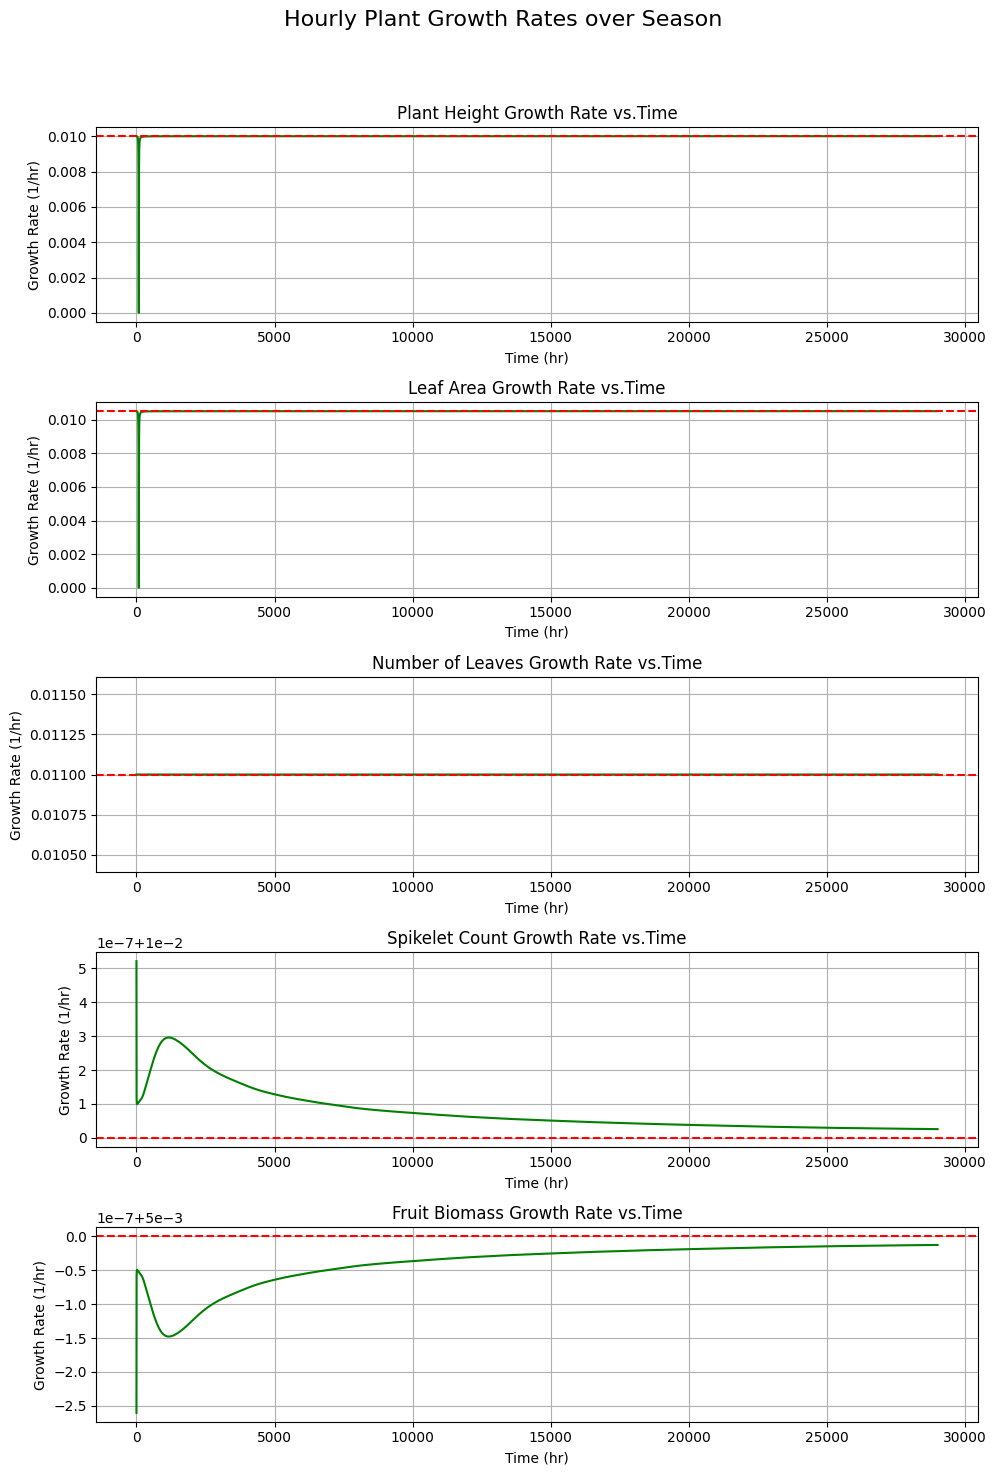

In [25]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass growth rates over time
fig, axs = plt.subplots(5, 1, figsize=(10, 15))
time = np.arange(len(ah_hat))

# Plant Height Growth Rate
axs[0].plot(time, ah_hat, color='green')
axs[0].axhline(y=growth_rates.ah, color='red', linestyle='--', linewidth=1.5)
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Growth Rate (1/hr)')
axs[0].set_title(f'Plant Height Growth Rate vs.Time')
axs[0].grid(True)

# Leaf Area Growth Rate
axs[1].plot(time, aA_hat, color='green')
axs[1].axhline(y=growth_rates.aA, color='red', linestyle='--', linewidth=1.5)
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Growth Rate (1/hr)')
axs[1].set_title(f'Leaf Area Growth Rate vs.Time')
axs[1].grid(True)

# Number of Leaves Growth Rate
axs[2].plot(time, aN_hat, color='green')
axs[2].axhline(y=growth_rates.aN, color='red', linestyle='--', linewidth=1.5)
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Growth Rate (1/hr)')
axs[2].set_title(f'Number of Leaves Growth Rate vs.Time')
axs[2].grid(True)

# Spikelet Count Growth Rate
axs[3].plot(time, ac_hat, color='green')
axs[3].axhline(y=growth_rates.ac, color='red', linestyle='--', linewidth=1.5)
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Growth Rate (1/hr)')
axs[3].set_title(f'Spikelet Count Growth Rate vs.Time')
axs[3].grid(True)

# Fruit Biomass Growth Rate
axs[4].plot(time, aP_hat, color='green')
axs[4].axhline(y=growth_rates.aP, color='red', linestyle='--', linewidth=1.5)
axs[4].set_xlabel('Time (hr)')
axs[4].set_ylabel('Growth Rate (1/hr)')
axs[4].set_title(f'Fruit Biomass Growth Rate vs.Time')
axs[4].grid(True)

fig.suptitle(f'Hourly Plant Growth Rates over Season', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Plot carrying capacities over time

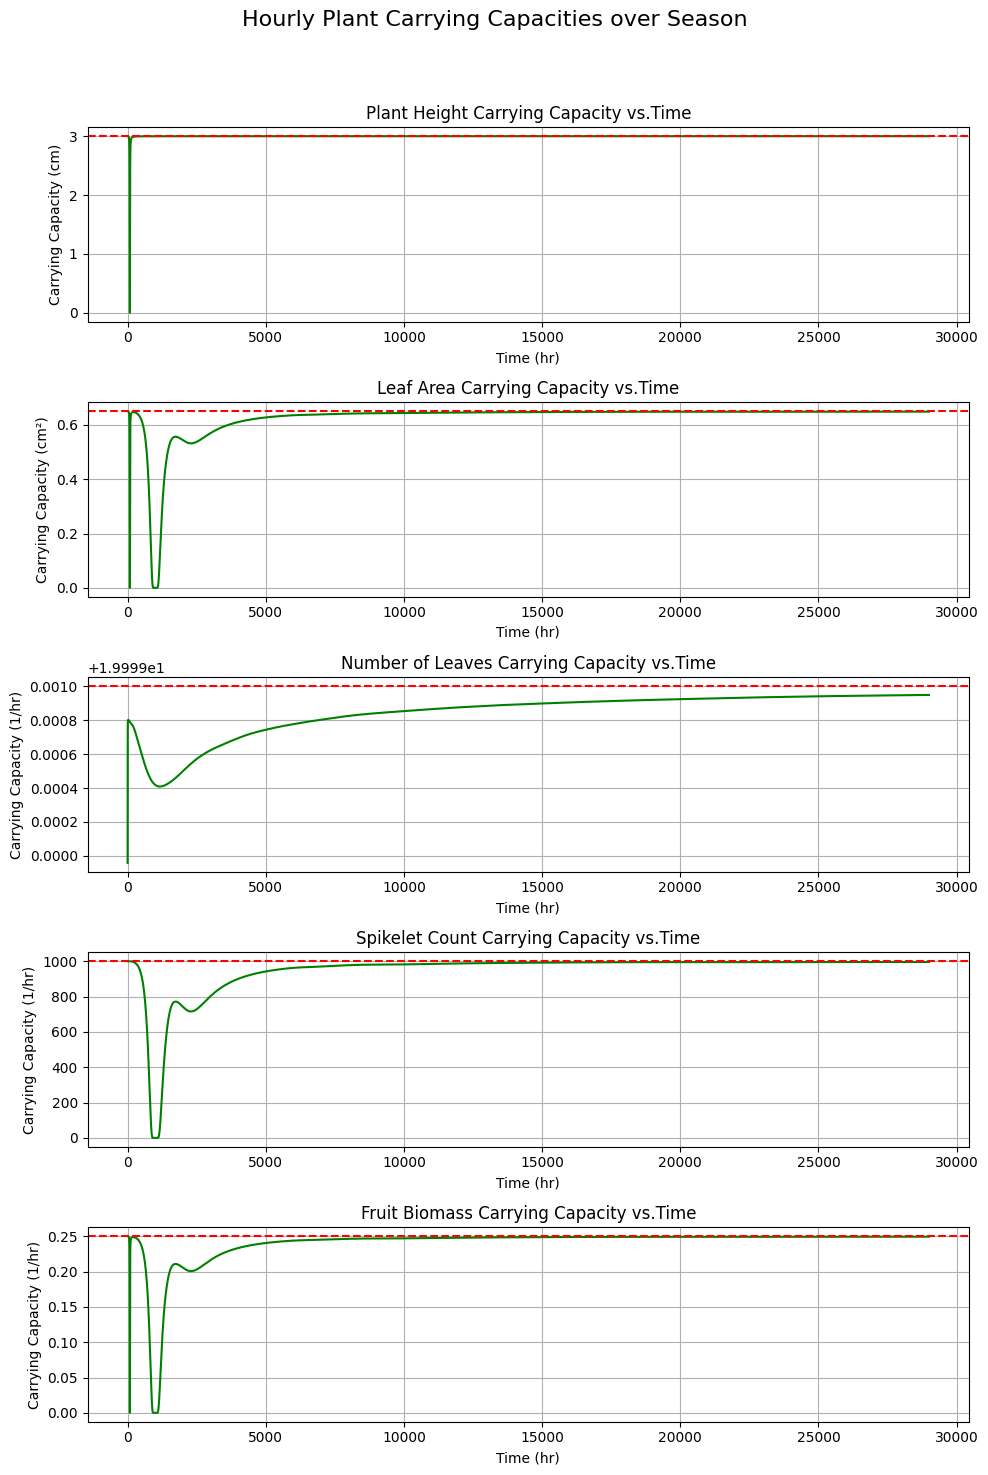

In [26]:
# Plot the height, leaf area, number of leaves, spikelet count, and fruit biomass carrying capacities over time
fig, axs = plt.subplots(5, 1, figsize=(10, 15))
time = np.arange(len(kh_hat))

# Plant Height Carrying Capacity
axs[0].plot(time, kh_hat, color='green')
axs[0].axhline(y=carrying_capacities.kh, color='red', linestyle='--', linewidth=1.5)
axs[0].set_xlabel('Time (hr)')
axs[0].set_ylabel('Carrying Capacity (cm)')
axs[0].set_title(f'Plant Height Carrying Capacity vs.Time')
axs[0].grid(True)

# Leaf Area Carrying Capacity
axs[1].plot(time, kA_hat, color='green')
axs[1].axhline(y=carrying_capacities.kA, color='red', linestyle='--', linewidth=1.5)
axs[1].set_xlabel('Time (hr)')
axs[1].set_ylabel('Carrying Capacity (cm²)')
axs[1].set_title(f'Leaf Area Carrying Capacity vs.Time')
axs[1].grid(True)

# Number of Leaves Carrying Capacity
axs[2].plot(time, kN_hat, color='green')
axs[2].axhline(y=carrying_capacities.kN, color='red', linestyle='--', linewidth=1.5)
axs[2].set_xlabel('Time (hr)')
axs[2].set_ylabel('Carrying Capacity (1/hr)')
axs[2].set_title(f'Number of Leaves Carrying Capacity vs.Time')
axs[2].grid(True)

# Spikelet Count Carrying Capacity
axs[3].plot(time, kc_hat, color='green')
axs[3].axhline(y=carrying_capacities.kc, color='red', linestyle='--', linewidth=1.5)
axs[3].set_xlabel('Time (hr)')
axs[3].set_ylabel('Carrying Capacity (1/hr)')
axs[3].set_title(f'Spikelet Count Carrying Capacity vs.Time')
axs[3].grid(True)

# Fruit Biomass Carrying Capacity
axs[4].plot(time, kP_hat, color='green')
axs[4].axhline(y=carrying_capacities.kP, color='red', linestyle='--', linewidth=1.5)
axs[4].set_xlabel('Time (hr)')
axs[4].set_ylabel('Carrying Capacity (1/hr)')
axs[4].set_title(f'Fruit Biomass Carrying Capacity vs.Time')
axs[4].grid(True)

fig.suptitle(f'Hourly Plant Carrying Capacities over Season', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()